In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch import Tensor
from datetime import datetime
import math
import random
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from network import *
from neural import *

In [2]:
initLogging("Common init")

dtype = torch.float
log("dtype", dtype)

dvc = torch.device("cpu")
log("device", dvc.type)

contextSize = 3
log("contextSize", contextSize)

Common init:         -------------------------- 2023-07-21 17:02:38
dtype:               torch.float32
device:              cpu
contextSize:         3


In [3]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:        -------------------------- 2023-07-21 17:02:38
filePath:            ../../data/names.txt
First few words:     ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:        32033
Vocabulary:          ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:  3.2958


In [4]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("wordShufflingSeed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:     -------------------------- 2023-07-21 17:02:39
wordShufflingSeed:   42
data dtype:          torch.int64
trRatio:             0.8
devRatio:            0.9
Training:            length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:          length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [6]:
logSection("Build network")

embeddingDims = 10
log("embeddingDims", embeddingDims)

hiddenLayerSize = 200
log("hiddenLayerSize", hiddenLayerSize)

learningSeed = 2147483647
log("learningSeed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dvc)
log("parametersCount", sum(p.nelement() for p in np.all))

@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:       -------------------------- 2023-07-21 17:02:51
embeddingDims:       10
hiddenLayerSize:     200
learningSeed:        2147483647
W1ratio:             0.2
b1ratio:             0.01
W2ratio:             0.1
b2ratio:             0
parametersCount:     11897


Learning:            -------------------------- 2023-07-21 17:02:53
trainingBatchSize:   32
trainingSteps: :     5708
maxIteration:        2000
repeats:             36
maxLr:               0.14
minLr:               0.0001
actualIterations:    2000
  0,      0 losses:     0.0000       3.7052     3.7038     3.7054
Break at max iteration:
 final losses:          2.0131       2.3242     2.3257     2.3249
emb.shape:           [32, 3, 10]
logits.shape:        [32, 27]


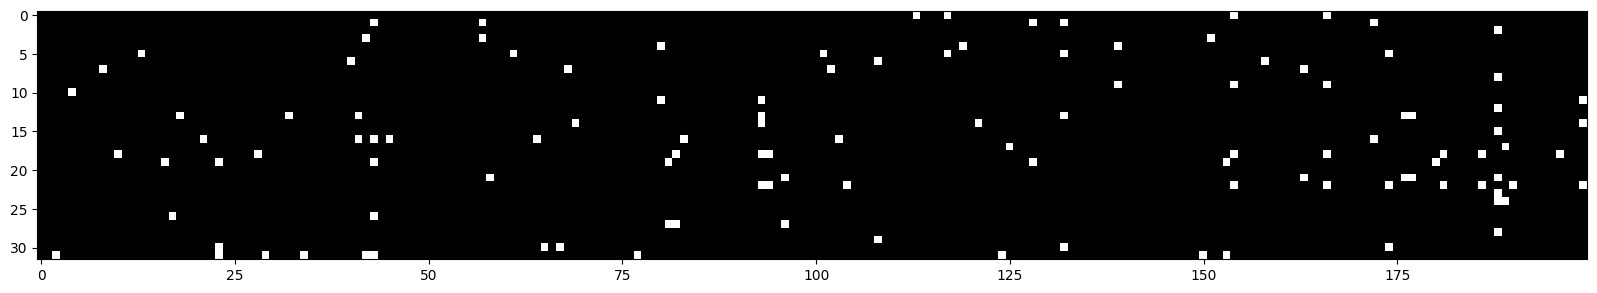

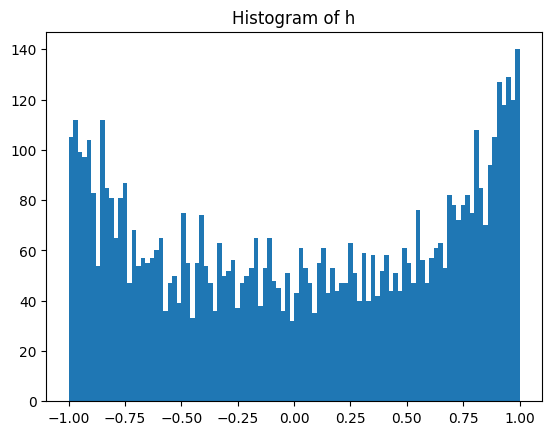

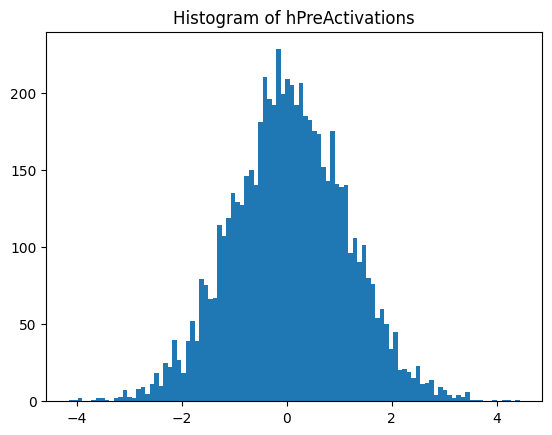

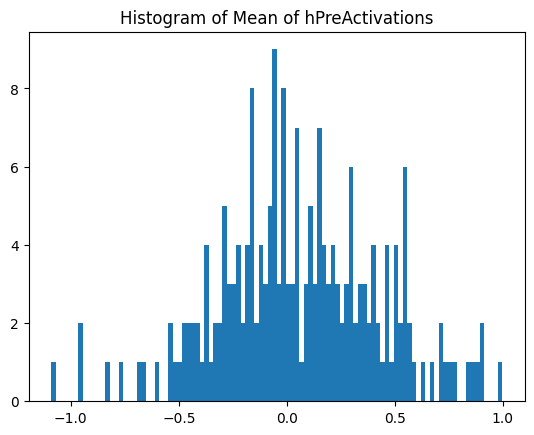

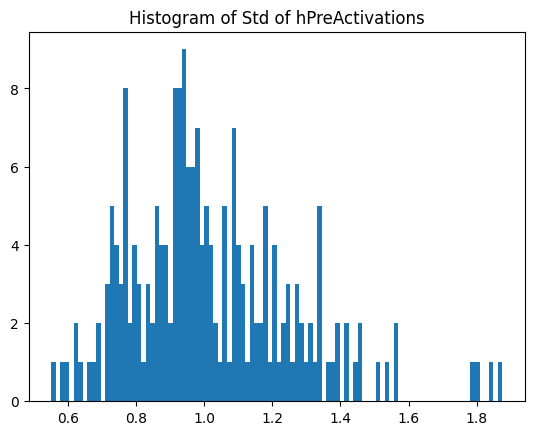

In [7]:
logSection("Learning")

trainingBatchSize = 32
log("trainingBatchSize", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("trainingSteps: ", trainingSteps)

maxIteration = 200_000
log("maxIteration", maxIteration)

repeats = 36
log("repeats",repeats)

maxLr = 0.14
log("maxLr", maxLr)

minLr = 0.0001
log("minLr", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("actualIterations", actualIterations)

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
i = 0
lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre

for repeat in range(repeats):
    
    if i >= maxIteration:
        break;

    logSimple(f"{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            log("Break at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20, 10))
            plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")
            
            plt.figure()
            plt.hist(fr.h.view(-1).tolist(), 100)
            plt.title('Histogram of h')

            plt.figure()
            plt.hist(fr.hPreActivations.view(-1).tolist(), 100)
            plt.title('Histogram of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.mean(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Mean of hPreActivations')

            plt.figure()
            plt.hist(fr.hPreActivations.std(0, keepdim=True).view(-1).tolist(), 100)
            plt.title('Histogram of Std of hPreActivations')

        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())
        
        i += 1

logSimple(f" final losses: {fr.loss.item():>15.4f}   ", end="")
logLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#log("best learning rate", bestLr)
log("emb.shape", fr.emb.shape)
#log("h.shape", fr.h.shape)
log("logits.shape", fr.logits.shape)

In [8]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:            -------------------------- 2023-07-21 17:03:00
samplingSeed:        2147483657
maxSampleLength:     50


In [10]:
samples = sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

mrikahmyazhizelmedhnylla.  59: 21 6 75 31 44 33 10 8 11 8 10 21 6 25 40 4 38 9 18 42 4 26 20 60 70 
emmrscendrlen.         15: 4 31 19 9 5 16 24 35 21 22 7 44 77 100 
azered.                48: 13 14 34 32 12 4 53 
tlin.                  83: 11 6 52 69 106 
shp.                  107: 17 80 4 44 
jen.                  286: 30 28 56 55 
edenneqtrxarlelyzimhlkelin.  10: 4 6 21 110 35 24 2 32 28 3 2 17 21 80 21 20 2 23 4 2 15 7 55 33 28 128 106 
shdbnrgxhiriest.       35: 17 80 2 1 32 4 2 5 7 23 37 40 10 11 40 45 
juhrwellelanthulfiu.   98: 30 34 38 18 1 82 55 115 58 19 41 85 5 52 3 77 1 59 1 38 
zayvder.               51: 11 111 22 9 5 52 13 137 
jahlemekg.            122: 30 125 19 26 56 10 22 5 21 22 
kaysh.                328: 35 84 25 25 72 93 
skmyla.                89: 17 5 18 17 69 59 56 
hal.                   57: 5 119 36 37 
salynnsuf.             81: 17 39 14 47 125 96 2 11 16 65 
zalel.                 91: 11 111 40 30 36 49 
juren.                213: 30 34 12 25 80 85 
cryvn

In [134]:
def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<21}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

.                    1      : 0 
m.                   1      : 7 0 
mi.                  12     : 7 78 0 
mic.                 50     : 7 78 44 10 
mich.                72     : 7 78 44 101 34 
micha.               60     : 7 78 44 101 107 9 
michal.              50     : 7 78 44 101 107 7 23 
michael.             68     : 7 78 44 101 107 13 179 47 
michaela.            71     : 7 78 44 101 107 13 179 39 133 
michaella.           69     : 7 78 44 101 107 13 179 19 82 194 
michel.              67     : 7 78 44 101 44 62 51 
michalx.             12     : 7 78 44 101 107 7 0 8 
michalxx.            13     : 7 78 44 101 107 7 0 1 190 
michalxxx.           7      : 7 78 44 101 107 7 0 1 0 23 
martin.              58     : 7 111 64 3 50 100 174 
andrej.              22     : 4 47 26 41 82 1 77 
andrey.              34     : 4 47 26 41 82 20 106 
joey.                97     : 11 53 29 13 197 
james.               96     : 11 105 22 39 31 89 
xin.                 126    : 12 60 25 85 
maxim.  

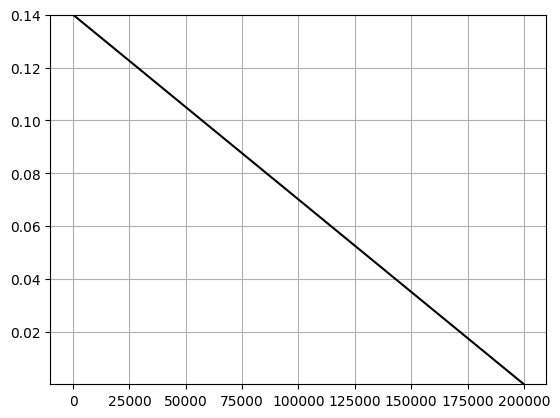

Actual min max LR 0.14 0.0001006994999999955


In [135]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print("Actual min max LR", max(lrAtIx), min(lrAtIx))

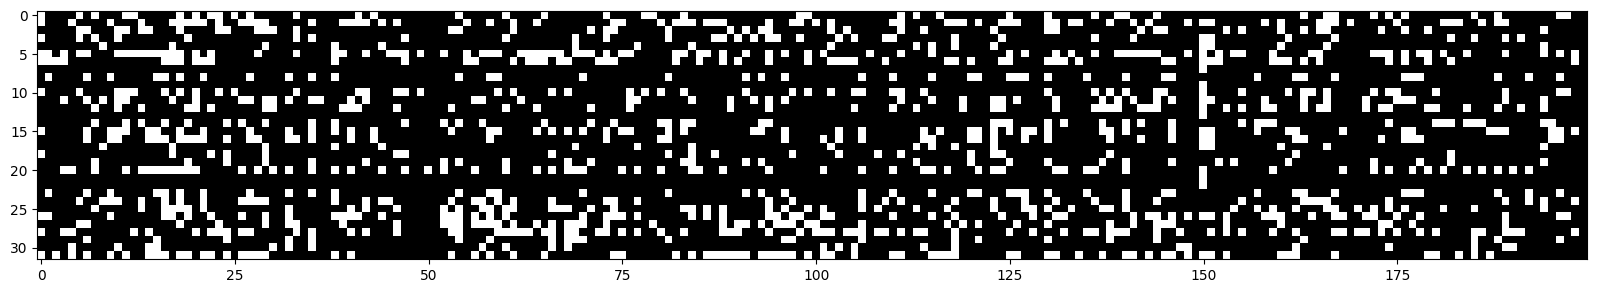

In [136]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

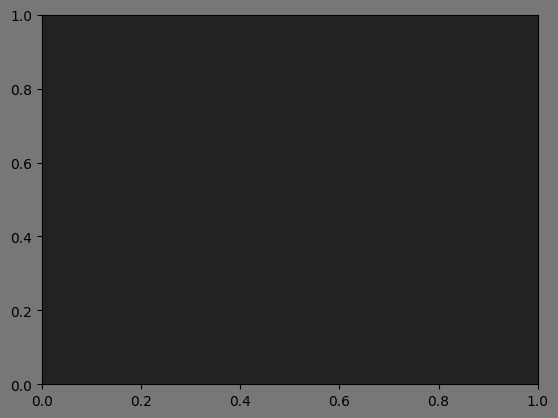

In [137]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

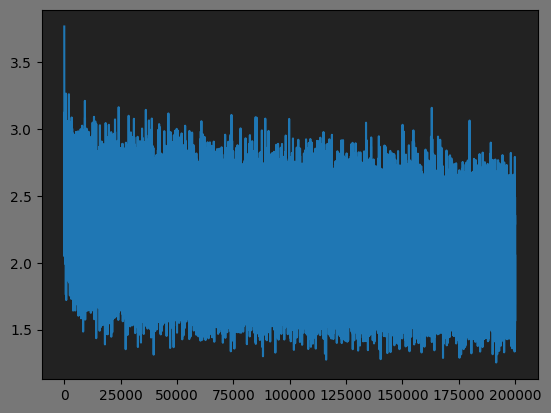

In [138]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

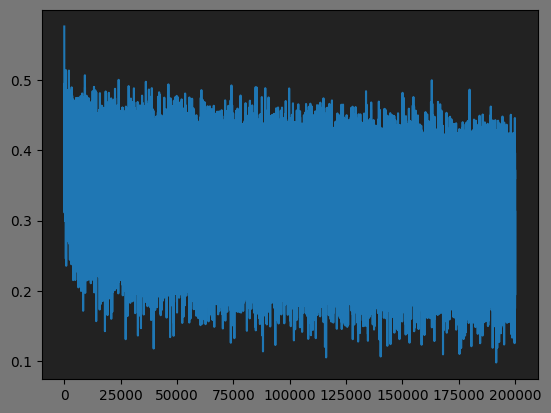

In [139]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

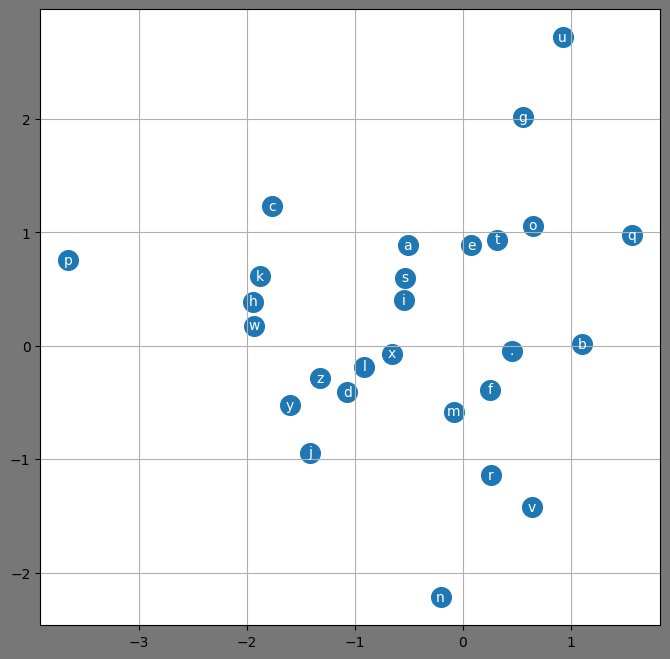

In [140]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid()

In [141]:
#np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

In [142]:
# Let"s suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let"s log the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
